In [1]:
from astropy.table import Table, column, vstack
import astropy.units as u
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
morph_data = Table.read('fits/morph_data.fits')
structure_data = Table.read('fits/structure_data.fits')
hi_data = Table.read('fits/hi_data.fits')

gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

#### Sample selection

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


148598 galaxies in 0.01 < z < 0.055
+ 136770 have HI
+ 122776 have bulge+disc masses
+ 93351 are mass complete


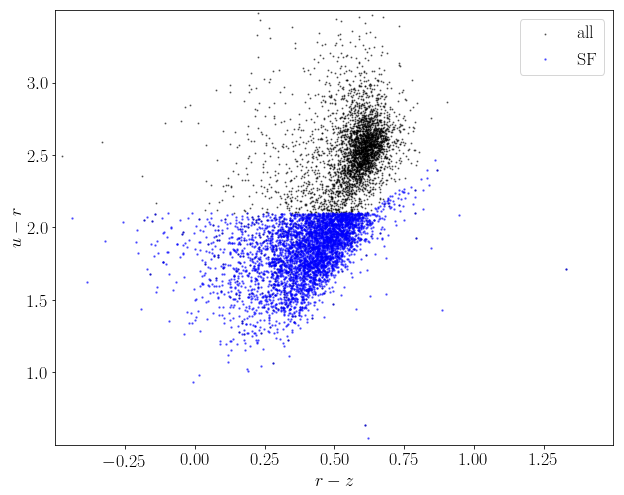

In [3]:
spiral_ok = np.all([morph_data['p_spiral'] >= 0.5,
                    morph_data['N_spiral'] >= 5,
                    morph_data['axial_ratio'] >= 0.4],axis=0)

redshift_ok = np.all([morph_data['redshift'] >= 0.01,
                      morph_data['redshift'] <= 0.085],axis=0)

hi_ok = hi_data['hi_mass'] > 0 

mass_ok = np.all([structure_data['m_b'] >= 10**7,
                  structure_data['m_d'] >= 10**7,
                  structure_data['ok']],axis=0)
mass_complete_lower = (np.log10(structure_data['m_t']) 
                    >= 2.07*np.log10(morph_data['redshift']) + 12.64)
                       
mass_complete_upper = (np.log10(structure_data['m_t']) 
                    <= 2.45*np.log10(morph_data['redshift']) + 14.05)

mass_complete = np.all([mass_complete_lower,mass_complete_upper],axis=0)

print('{} galaxies in 0.01 < z < 0.055'.format(redshift_ok.sum()))
print('+ {} have HI'.format((redshift_ok*hi_ok).sum()))
print('+ {} have bulge+disc masses'.format((redshift_ok*hi_ok*mass_ok).sum()))
print('+ {} are mass complete'.format((redshift_ok*hi_ok*mass_ok*mass_complete).sum()))

# --- Select star-forming ---
u_r = gz2_data['PETROMAG_MU'] - gz2_data['PETROMAG_MR']
r_z = gz2_data['PETROMAG_MR'] - gz2_data['PETROMAG_MZ']
star_forming = np.any([u_r < 2.1,u_r < 1.6*r_z + 1.1],axis=0)

_ = plt.scatter(r_z[:4000],u_r[:4000],color='k',s=1,alpha=0.5,label='all')
_ = plt.scatter(r_z[star_forming][:4000],u_r[star_forming][:4000],
                color='b',s=2,alpha=0.5,label='SF')
_ = plt.axis((-0.5,1.5,0.5,3.5))
_ = plt.xlabel('$r-z$')
_ = plt.ylabel('$u-r$')
_ = plt.legend()

masks = Table()
masks['in_redshift'] = redshift_ok
masks['mass_ok'] = mass_ok
masks['mass_complete'] = mass_complete
masks['hi_ok'] = hi_ok
masks['star_forming'] = star_forming

masks.write('fits/masks.fits',overwrite=True)

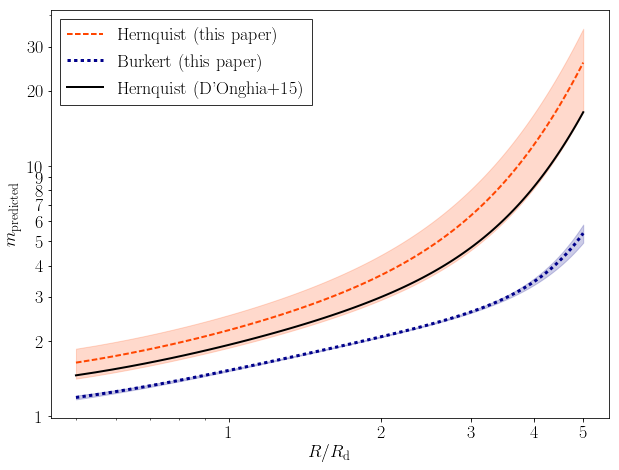

In [4]:
from halo import TotalHalo

fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)

### Milky Way for reference #######

m_b_mw = [4e9] * u.Msun
delta_m_b_mw = [0] * u.Msun

m_d_mw = [5.6e10] * u.Msun
delta_m_d_mw = [0.5e10] * u.Msun

a_b_mw = [0.6] * u.kpc
delta_a_b_mw = [0] * u.kpc

R_d_mw = [2.15] * u.kpc
delta_R_d_mw = [0.14] * u.kpc

m_hi_mw = None
delta_m_hi_mw = None

m_halo_mw = [9.5e11] * u.Msun
delta_m_halo_mw = [0.2] * m_halo_mw

R_halo_mw = [29.6] * u.kpc
delta_R_halo_mw = [0.2] * R_halo_mw

d15_halo = TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,a_b_mw,
                     delta_a_b_mw,R_d_mw,delta_R_d_mw,m_hi_mw,delta_m_hi_mw,
                     m_halo_mw,delta_m_halo_mw,R_halo_mw,delta_R_halo_mw,1,0)

mw_halo = TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,a_b_mw,
                    delta_a_b_mw,R_d_mw,delta_R_d_mw,m_hi_mw,delta_m_hi_mw,
                    None,None,None,None,1,0)

#ys = np.linspace(0.25,4,100)
m_d15 = d15_halo.m_hernquist()
m_hernquist = mw_halo.m_hernquist()
m_burkert = mw_halo.m_burkert()
ms = [m_hernquist,m_burkert,m_d15]
                 
labels = ('Hernquist (this paper)','Burkert (this paper)',
          "Hernquist (D'Onghia+15)")

colors = ('orangered','darkblue','k')
linestyles = ('dashed','dotted','solid')
linewidths = (2,3,2)
errorbars = (True, True, False)


for (m,c,s,w,l,e) in zip(ms,colors,linestyles,linewidths,labels,errorbars):
    _ = ax.plot(m['R']/R_d_mw,m['m'],
                color=c,lw=w,linestyle=s,label=l)
    if e is True:
        _ = ax.fill_between((m['R']/R_d_mw).data,(m['m']+m['error']).data,
                            (m['m']-m['error']).data,
                            color=c,alpha=0.2,label='_nolegend_')
        

_ = ax.legend(edgecolor='k',fancybox=False,loc='upper left')
_ = ax.set_xlabel('$R/R_\mathrm{d}$')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

_ = ax.set_xticks([1,2,3,4,5])
_ = ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
_ = ax.set_yticks([1,2,3,4,5,6,7,8,9,10,20,30])
_ = ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

fig.savefig('figures/milky_way.pdf')

In [5]:
sample_ok = np.all([redshift_ok,mass_ok,hi_ok],axis=0)
# only do 1000 to save time for now...
#sample_adjust = np.argwhere(sample_ok == True)[1000:]
#sample_ok[sample_adjust] = False


m_b = structure_data['m_b'][sample_ok].data * u.Msun
delta_m_b = structure_data['delta_m_b'][sample_ok].data * u.Msun

m_d = structure_data['m_d'][sample_ok].data * u.Msun
delta_m_d = structure_data['delta_m_d'][sample_ok].data * u.Msun

a_b = structure_data['R_b'][sample_ok].data * u.kpc
delta_a_b = structure_data['delta_R_b'][sample_ok].data * u.kpc

R_d = structure_data['R_d'][sample_ok].data * u.kpc
delta_R_d = structure_data['delta_R_d'][sample_ok].data * u.kpc

m_hi = hi_data['hi_mass'][sample_ok].data * u.Msun
delta_m_hi = hi_data['hi_mass_error'][sample_ok].data * u.Msun
#fig, axarr = plt.subplots(2,4,figsize=(20,10))

halos = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,a_b,delta_a_b,
                  R_d, delta_R_d, None, None)

halos_w_gas = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,a_b,delta_a_b,
                        R_d, delta_R_d, m_hi, delta_m_hi)

In [6]:
class HistogramData():
    def __init__(self,data,data2,color,bins,log,alpha=0.3,color2='k'):
        self.data = data
        self.data2 = data2
        self.color = color
        self.bins = bins
        self.log = log
        self.alpha = alpha
        self.color2 = color2
        
    def histogram(self,ax):
        histdata = (np.log10(self.data.data) 
                    if self.log is True else self.data.data)
        _ = ax.hist(histdata,self.bins,
                    histtype='stepfilled',color=self.color,alpha=self.alpha)
        _ = ax.hist(histdata,self.bins,histtype='step',color=self.color)
        if self.data2 is not None:
            histdata2 = (np.log10(self.data2.data) 
                         if self.log is True else self.data2.data)
            _ = ax.hist(histdata2,self.bins,histtype='step',lw=3,color=self.color2)
            
    def uncertainty(self,data):
        if self.log is False:
            med_error = np.median(data.uncertainty.array)
        else:
            med_error = 0.434 * np.median(data.uncertainty.array
                                         /data.data)
        return med_error
        
            
    def uncertainty_bar(self,ax):
        (xlower,xupper), (ylower,yupper) = (ax.get_xlim(), ax.get_ylim())
        med_error = self.uncertainty(self.data)
        x_pos, y_pos = (0.05*(xupper-xlower) + xlower,
                        0.85*(yupper-ylower) + ylower)
        _ = ax.errorbar(x_pos,y_pos,xerr=([0],[med_error]),
                        lw=2,capthick=2,capsize=2,color=self.color)
        
        if self.data2 is not None:
            med_error = self.uncertainty(self.data2)
            x_pos, y_pos = (0.05*(xupper-xlower) + xlower,
                            0.75*(yupper-ylower) + ylower)
            _ = ax.errorbar(x_pos,y_pos,xerr=([0],[med_error]),
                            lw=2,capthick=2,capsize=2,color=self.color2)
            
    def median_line(self,ax,printout=False,**kwargs):
        plt.sca(ax)
        med_ = (np.median(np.log10(self.data)) if self.log is True 
                else np.median(self.data))
        _ = plt.axvline(med_,color=self.color,**kwargs)
        print(med_) if printout is True else None
            
        if self.data2 is not None:
            med_ = (np.median(np.log10(self.data2)) if self.log is True 
                else np.median(self.data2))
            _ = plt.axvline(med_,color=self.color2,**kwargs)
            print(med_) if printout is True else None


data = [HistogramData(halos_w_gas.disc_mass(hi=False),
                      halos_w_gas.disc_mass(hi=True),
                      'y',np.linspace(8,12,21),True),
        
        HistogramData(halos_w_gas.stellar_disc_scale_length(),
                      halos_w_gas.disc_scale_length(),
                      'y',np.linspace(0,10,21),False),
        
        HistogramData(halos_w_gas.bulge_mass(),None,
                      'b',np.linspace(8,12,21),True),
       
        HistogramData(halos_w_gas.bulge_scale_length(),None,
                      'b',np.linspace(0,2.5,21),False),
        
        HistogramData(halos_w_gas.halo_mass(),None,
                      'r',np.linspace(10,14,21),True),
        
        HistogramData(halos_w_gas.halo_scale_length(),None,
                      'r',np.linspace(5,65,21),False)]

10.0500001907
10.3003362926
1.4888888465
1.56407389386
10.267999649
0.434463983888
12.107615095
27.5797919605


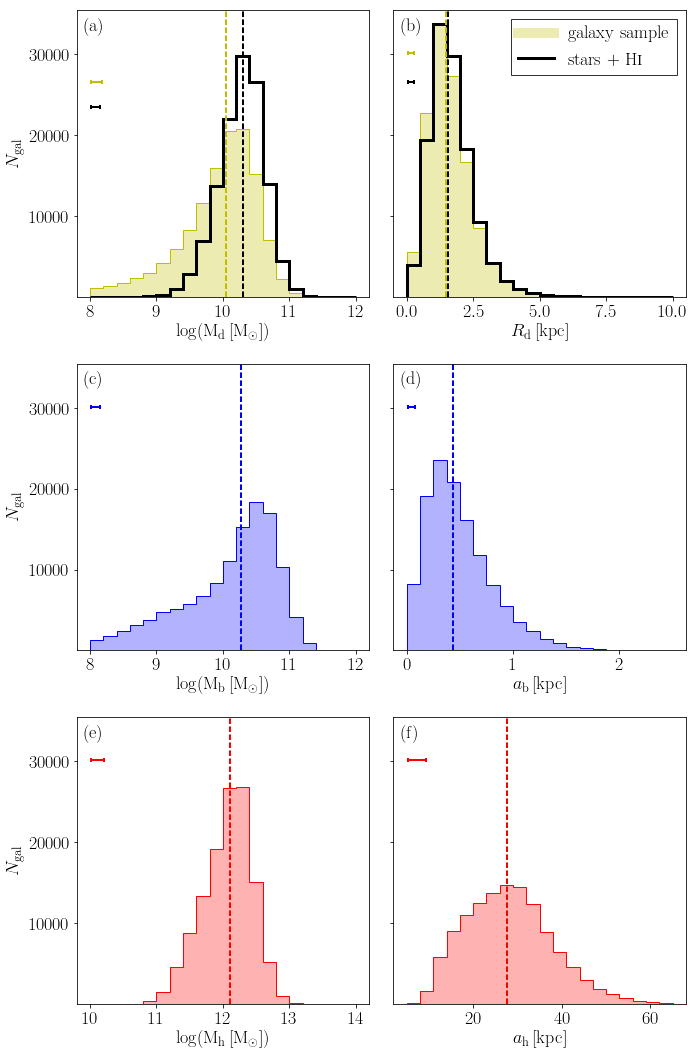

In [10]:
fig, axarr = plt.subplots(3,2,figsize=(10,15),sharey=True)

xlabels = ('$\log(\mathrm{M_d} \, [\mathrm{M_\odot}])$',
           '$R_\mathrm{d} \, [\mathrm{kpc}]$',
           '$\log(\mathrm{M_b} \, [\mathrm{M_\odot}])$',
           '$a_\mathrm{b} \, [\mathrm{kpc}]$',
           '$\log(\mathrm{M_h} \, [\mathrm{M_\odot}])$',
           '$a_\mathrm{h} \, [\mathrm{kpc}]$')

letters = 'abcdef'

for ax in axarr[:,0]:
    ax.set_ylabel('$N_\mathrm{gal}$')
    
axarr = axarr.ravel()

for ax, d, xlabel,letter in zip(axarr,data,xlabels,letters):
    plt.sca(ax)
    _ = d.histogram(ax)
    _ = d.median_line(ax,True,lw=2,linestyle='dashed')
    _ = d.uncertainty_bar(ax)
    _ = ax.set_xlabel(xlabel)
    _ = ax.text(0.025,0.975,'({})'.format(letter),
                transform=ax.transAxes,ha='left',va='top')
    
_ = fig.tight_layout()

_ = axarr[1].plot([],[],color='y',lw=10,alpha=0.3,label='galaxy sample')
_ = axarr[1].plot([],[],color='k',lw=3,label=r'stars + H\textsc{i}')
_ = axarr[1].legend(loc='upper right',
                    edgecolor='k',fancybox=False)

fig.savefig('figures/parameter_histograms.pdf')

In [11]:
def get_halo_table(halos):

    halo_table = Table()

    halo_table['M_disc_stars'] = halos.disc_mass(hi=False).data
    halo_table['delta_M_disc_stars'] = halos.disc_mass(hi=False).uncertainty.array

    halo_table['M_disc_total'] = halos.disc_mass(hi=True).data
    halo_table['delta_M_disc_total'] = halos.disc_mass(hi=True).uncertainty.array

    halo_table['R_disc_stars'] = halos.stellar_disc_scale_length().data
    halo_table['delta_R_disc_stars'] = halos.stellar_disc_scale_length().uncertainty.array

    halo_table['R_disc_total'] = halos.disc_scale_length().data
    halo_table['delta_R_disc_total'] = halos.disc_scale_length().uncertainty.array

    halo_table['M_bulge'] = halos.bulge_mass().data
    halo_table['delta_M_bulge'] = halos.bulge_mass().uncertainty.array

    halo_table['R_bulge'] = halos.bulge_scale_length().data
    halo_table['delta_R_bulge'] = halos.bulge_scale_length().uncertainty.array

    halo_table['M_halo'] = halos.halo_mass().data
    halo_table['delta_M_halo'] = halos.halo_mass().uncertainty.array

    halo_table['R_halo'] = halos.halo_scale_length().data
    halo_table['delta_R_halo'] = halos.halo_scale_length().uncertainty.array

    r_d = [1,1.5,2,2.2]
    for r in r_d:
        m_hernquist_pred = halos.m_hernquist(y=r/2)
        m_burkert_pred = halos.m_burkert(y=r/2)
        halo_table['m_hernquist_{}R_d'.format(r)] = m_hernquist_pred['m']

        halo_table['m_burkert_{}R_d'.format(r)] = m_burkert_pred['m']
        
    halo_table['M_disc_stars_2.2'] = halos.M_disc_22(False).data
    halo_table['delta_M_disc_stars_2.2'] = halos.M_disc_22(False).uncertainty.array
    
    halo_table['M_disc_total_2.2'] = halos.M_disc_22(True).data
    halo_table['delta_M_disc_total_2.2'] = halos.M_disc_22(True).uncertainty.array
    
    halo_table['M_bulge_2.2'] = halos.M_bulge_22().data
    halo_table['delta_M_bulge_2.2'] = halos.M_bulge_22().uncertainty.array
    
    halo_table['M_halo_2.2_hernquist'] = halos.M_halo_22_hernquist().data
    halo_table['delta_M_halo_2.2_hernquist'] = halos.M_halo_22_hernquist().uncertainty.array
    
    halo_table['M_halo_2.2_burkert'] = halos.M_halo_22_burkert().data
    halo_table['delta_M_halo_2.2_burkert'] = halos.M_halo_22_burkert().uncertainty.array
        
    return halo_table

In [12]:
halo_table = get_halo_table(halos)
halo_table_w_gas = get_halo_table(halos_w_gas)

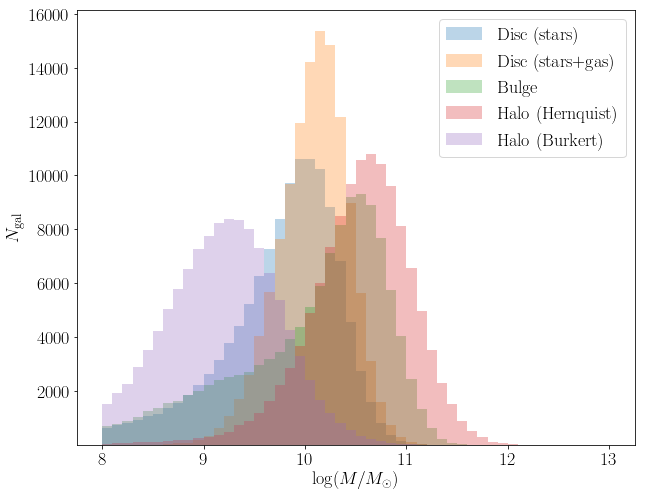

In [15]:
bins = np.linspace(8,13,51)
cols = ['M_disc_stars_2.2','M_disc_total_2.2',
        'M_bulge_2.2','M_halo_2.2_hernquist','M_halo_2.2_burkert']

labels = ('Disc (stars)', 'Disc (stars+gas)',
          'Bulge', 'Halo (Hernquist)', 'Halo (Burkert)')

for c, l in zip(cols,labels):
    histdata = np.log10(halo_table_w_gas[c])
    _ = plt.hist(histdata,bins,alpha=0.3,label=l)
    
_ = plt.legend()
_ = plt.xlabel('$\log(M/M_\odot)$')
_ = plt.ylabel('$N_\mathrm{gal}$')

In [16]:
halo_table_all = Table()
for c in halo_table.colnames:
    halo_table_all[c] = np.full(len(gz2_data),-999,dtype='float64')
    halo_table_all[c][sample_ok] = halo_table[c]

halo_table_all['dr7objid'] = gz2_data['dr7objid']
halo_table_all['mask'] = sample_ok

halo_table.write('fits/halo_table.fits',overwrite=True)
halo_table_all.write('fits/halo_table_all.fits',overwrite=True)

In [17]:
halo_table_all_w_gas = Table()
for c in halo_table_w_gas.colnames:
    halo_table_all_w_gas[c] = np.full(len(gz2_data),-999,dtype='float64')
    halo_table_all_w_gas[c][sample_ok] = halo_table_w_gas[c]

halo_table_all_w_gas['dr7objid'] = gz2_data['dr7objid']
halo_table_all_w_gas['mask'] = sample_ok

halo_table_w_gas.write('fits/halo_table_w_gas.fits',overwrite=True)
halo_table_all_w_gas.write('fits/halo_table_all_w_gas.fits',overwrite=True)